In [1]:
import sys
import math

import pandas as pd
import numpy as np

sys.path.append('../../../..')
from livsim import Cow
from livsim import Feed
from livsim import FeedStorage

from matplotlib import pyplot as plt

from IPython.display import HTML, display_html

display_html(HTML(filename="./css.html"))

### __Introduction__

In this workbook the LIVSIM-model will be tested against the experimental results from [Jenet _et al._ 2004](https://doi.org/10.1017/S1357729800054114). In the first part of the workbook a brief overview of the rationale, methods, and results of the study will be given. In the second part the setup of the model will be described and in the third part livestock will be simulated with LIVSIM and the outcomes compared to the experimental data from Jenet _et al._ 2004.

##### __Rationale__
Indigenous cattle breeds (_Bos taurus indicus_)[<sup>*</sup>](#fn1) are adapted to harsh conditions and, when under-nourished, will replenish body reserves when given an improved diet, rather than increase milk yield substantially. To improve milk yields in the tropics it has been common practice to introduce improved cattle breeds (_B. taurus taurus_)[<sup>*</sup>](#fn1) for decades. Since _B. taurus taurus_ has little resistance against tropical diseases crossbreds between _B. taurus indicus_ and _B. taurus taurus_ are typically created. These crossbreds do show an at least moderate reponse to improved feeding under tropical conditions. It is unclear, however, whether this improved milk yield is also present if the cattle are fed the same diet since before the first lactation starts. Additionally there may be differences in the requirements for maintenance and lactations between the crossbreds and _B. taurus indicus_. 

##### __Experimental setup__
In the present study both a crossbred (_Boran x Holstein_) and an indigenous (_Boran_) breed were fed at a fixed level of feeding: 1.0, 1.2, or 1.4 times metabolisable energy (ME) requirement for maintenance. Maintenance requirement was calculated, according to MAFF (1987), as $8.3 + 0.091 \cdot BW_f$ where BW<sub>f</sub> is the fasting body weight of the animal. Animals were weighed every 2 weeks and the amount of feed was adjusted according to changes in body weight. The diet always consisted of 65% Bermuda grass (_Cynadon dactylon_) hay and 35% wheat bran. For the ME-contents of the feed the estimates of MAFF (1987) were used: 7.5 MJ kg<sup>-1</sup> and 10.1 MJ kg<sup>-1</sup> for Bermuda grass and wheat bran, respectively.

<div class="alert alert-info">
    <h4><b>Notes:</b></h4>
    <ol>
        <li>In the first lactation cycle the animals were subjected to exercise between months 2 and 4 of the lactation cycle. This fact is not mentioned in either the results or the discussion of the paper.</li>
        <li>Milking continued until milk yield was less than 0.5 kg day<sup>-1</sup> or until 3 months in advance of the calculated calving date. <b>Check this in the simulation.</b></li>
        <li>The actual ME-contents of the feed were <i>a posteriori</i> determined to be higher than the <i>a priori</i> assumed ones. This means that for the amounts of feed offered the <i>a priori</i> estimates have to be used, but to calculate ME intake by the animals the actual values have to be used.</li>
    </ol>
</div>
<br />
<span id="fn1" style="font-size:12px;">* In the nomenclature followed here both types of breed are subspecies of <i>B. taurus</i>, rather than distinct species in the genus <i>Bos</i>. See also <a href="http://www.departments.bucknell.edu/biology/resources/msw3/browse.asp?id=14200687">here</a>.</span>

#### Preliminary checks

The discussion of Jenet _et al._ 2004 mentions that, due to the _a priori_ underestimation of the ME-content of the feed, the feeding level in the low-feeding scenario was between 1.1 and 1.2 times maintenance requirements, rather than the 1.0 times that was intended at the start of the experiment.

Table 2 in the paper gives us the information needed to make an estimation of the actual feeding level during both lactation cycles. In the cell below a number of things are calculated and summarized in a table called `df`.

1. In the paper the feed required (kg DM) to meet maintenance demands is calculated using the equation from MAFF (1987) and assuming both the _a priori_ estimates for the ME-content of 7.5 MJ kg DM<sup>-1</sup> and 10.1 MJ kg DM<sup>-1</sup> and the _a posteriori_ measured ME-contents of 9.6 MJ kg DM<sup>-1</sup> and 11 MJ kg DM<sup>-1</sup> for Bermuda grass hay and wheat bran, respectively. Here the reported body weight at the start of the lactation is used to calculate the maintenance requirements. The requirements and the feed ME-contents are then used to get an estimation of the amount of feed the animals should have received at each feeding level.
2. The reported dry matter intake is included in the table for easy comparison.
3. In the study both the systems of MAFF and AFRC are used to calculate the maintenance requirements and so do we.
4. The level of feeding is included calculated in five different ways:
    - The _a priori_ intended level of feeding (La)
    - Requirements according to MAFF (1987), _a priori_ ME-content
    - Requirements according to AFRC (1993), _a priori_ ME-content
    - Requirements according to MAFF (1987), _a posteriori_ ME-content
    - Requirements according to AFRC (1993), _a posteriori_ ME-content
5. The correction factor included in the table is the ratio between the feeding level according to the _a posteriori_ ME-content and the requirements according to AFRC and _a priori_ intended feeding level. This correction factor can be used in the simulation to correct the amount of feed offered to the animal.

In each case the calculations performed with the _a priori_ estimate are indicated with an 'a' and the ones performed with the measured values with a 'b'.

In [2]:
fraction_roughage = 0.65
fraction_concentrate = 0.35

roughage_ME_a = 7.5
concentrate_ME_a = 10.1

average_ME_a = fraction_roughage * roughage_ME_a + \
                fraction_concentrate * concentrate_ME_a

roughage_ME_b = 9.6
concentrate_ME_b = 11

average_ME_b = fraction_roughage * roughage_ME_b + \
                fraction_concentrate * concentrate_ME_b

data_cows = {
    'Boran': {
        'cycle 1': {
            'low': {
                'dm_intake': 4.73,
                'bw': 318
            },
            'medium': {
                'dm_intake': 5.66,
                'bw': 322
            },
            'high': {
                'dm_intake': 7.08,
                'bw': 374
            }
        },
        'cycle 2': {
            'low': {
                'dm_intake': 4.86,
                'bw': 330
            },
            'medium': {
                'dm_intake': 5.80,
                'bw': 328
            },
            'high': {
                'dm_intake': 7.48,
                'bw': 382
            }
        }      

    },
    'Boran x Friesian': {
        'cycle 1': {
            'low': {
                'dm_intake': 4.87,
                'bw': 336
            },
            'medium': {
                'dm_intake': 6.04,
                'bw': 347
            },
            'high': {
                'dm_intake': 7.88,
                'bw': 410
            }
        },
        'cycle 2': {
            'low': {
                'dm_intake': 5.10,
                'bw': 340
            },
            'medium': {
                'dm_intake': 5.90,
                'bw': 339
            },
            'high': {
                'dm_intake': 7.82,
                'bw': 400
            }
        }      
    }
}

res = {}
for breed in data_cows:
    
    breed_data = data_cows[breed]
    res[breed] = {}
    
    for cycle in breed_data:
        
        cycle_data = breed_data[cycle]
        res[breed][cycle] = {}
        
        for feeding_level in cycle_data:
            
            if feeding_level == 'low':
                k = 1
            elif feeding_level == 'medium':
                k = 1.2
            elif feeding_level == 'high':
                k = 1.4
            else:
                raise ValueError(f'Unknow feeding level: {feeding_level}')
            
            feeding_data = cycle_data[feeding_level]
            res[breed][cycle][feeding_level] = {}
            
            # The reported body weights are assumed to represent fasted body weight
            # the values are, therefore, used as is and not divided by 1.08 as is the
            # custom in the calculations according to MAFF and AFRC.
            bw = feeding_data['bw']
            dm_intake = feeding_data['dm_intake']
            
            # Maintenance requirement according to MAFF (1987)
            requirement_MAFF = 8.3 + 0.091 * bw
            
            # Maintenance requirements according to AFRC (1993)
            qm = 0.612  # see Jenet et al. 2004 p. 334
            f = 0.53 * bw**0.67
            a = 0.0095 * bw
            km = 0.35 * qm + 0.503
            requirement_AFRC = (f + a) / km
            
            # Amount of feed required according to estimation of maintenance ME based
            # on MAFF (1987) and the a priori estimate of ME-content of the feed.
            dm_required_a = requirement_MAFF / average_ME_a
            dm_required_b = requirement_MAFF / average_ME_b
            
            a_priori = requirement_MAFF * k
            a_posteriori_a = dm_intake * average_ME_a
            a_posteriori_b = dm_intake * average_ME_b
            
            res[breed][cycle][feeding_level]['dm_intake'] = dm_intake
            res[breed][cycle][feeding_level]['dm_required_a'] = dm_required_a * k
            res[breed][cycle][feeding_level]['dm_required_b'] = dm_required_b * k            
            res[breed][cycle][feeding_level]['a_priori'] = a_priori / requirement_MAFF
            res[breed][cycle][feeding_level]['a_posteriori_a_MAFF'] = a_posteriori_a / requirement_MAFF
            res[breed][cycle][feeding_level]['a_posteriori_a_AFRC'] = a_posteriori_a / requirement_AFRC           
            res[breed][cycle][feeding_level]['a_posteriori_b_MAFF'] = a_posteriori_b / requirement_MAFF
            res[breed][cycle][feeding_level]['a_posteriori_b_AFRC'] = a_posteriori_b / requirement_AFRC
            res[breed][cycle][feeding_level]['error'] = (a_posteriori_b / requirement_AFRC) / (a_priori / requirement_MAFF)
            

df = pd.DataFrame.from_dict({(i,j,k): res[i][j][k]
                           for i in res.keys() 
                           for j in res[i].keys()
                           for k in res[i][j].keys()},
                           orient='index')

df = df.round(2)
df.columns = ['DM intake', 'DM_req_a', 'DM_req_b', 'L_a', 'L_a_MAFF', 'L_a_AFRC', 'L_b_MAFF', 'L_b_AFRC', 'correction_factor']

HTML(df.to_html())

<div class="alert alert-box alert-warning">

If we use the _a priori_ estimates of the ME-content and use AFRC to calculate the maintenance requirements, the realized level of feeding is quite close to the intended level. However, if we use the the _a posteriori_ measured ME-contents of the feed we can see that the animals may have been fed quite a bit more than intended. The correction factor shows that on average the amount of feed needs to be adjusted by approximately 20% to match the simulation with the experiment.
    
In the calculations done here we used the body weight at the start of the lactation cycle to calculate the maintenance requirements. Since the body weight of the animals, and, therefore, the estimated maintenance requirements decrease during the lactation cycle the level of feeding reported in this table may be regarded as a minimum value. The average level of feeding over the cycle may well have been higher.

Feed was provided once daily, starting with wheat bran at 0700 h and followed by grass hay.

The animals were weighed every second week between 0700 and 0900 h after 12 h of fasting in
order to determine the fasting W.

### __Simulation setup__

#### __Activity__
During the first lactation cycle animals were exposed to work. In the experiment animals would either pull sledges or walk about for 5 hours per day. In the data analysis these groups are not distinguished, since animals were assigned a training regime in a balanced way. To account for the energy expenditure on activity in a single animal in the simulation we will create a training regime that has half of one type of exercise and half of the other.

The maintenance requirements according to AFRC are calculated as:

$$ \mathit{ME}_m = \dfrac{(f + a)}{k_m} $$

where $f$ is the fasting metabolism, $a$ the activity allowance and $k_m$ the ME use efficiency for maintenance. The fasting metabolism and activity allowance are calculated as:

\begin{align}
f &= 0.53 \cdot \left( \dfrac{bw}{1.08} \right)^{0.67} \\
\\
a &= (\mathit{ecs} + \mathit{ecbc} \cdot \mathit{bc} + \mathit{echm} \cdot \mathit{hm}) \cdot bw
\end{align}

In these equations $bw$ is the body weight of the animal, $ecs$ the energy cost for standing (MJ kg<sup>-1</sup>), $ecbc$ the energy cost for body changes (MJ change<sup>-1</sup> kg<sup>-1</sup>), $bc$ the number of body changes in a day, $echm$ is the energy cost for horizontal movement (MJ kg<sup>-1</sup> m<sup>-1</sup>), and $hm$ the horizontal movement (m).

| cycle | breed | feeding level | age (months) | bw (kg) |
| --- | --- | ---| :---: | :---: |
| 1 | Boran x Friesian | high | 44 | 420 |
| 1 | Boran x Friesian | medium | 44 | 400 | 
| 1 | Boran x Friesian | low | 44 | 360 |
| 1 | Boran | high | 70 | 364 |
| 1 | Boran | medium | 70 | 352 |
| 1 | Boran | low | 70 | 335 |
<caption>Age (months) and body weight (kg) for the animals at the start of the first lactation for both breeds and all three feeding levels.</caption>

| cycle | breed            | feeding level | calving interval (days) | lactation length (days) | milk (kg) |
| ----- | ---------------- | ------------- | :---------------------: | :---------------------: | :-------: |
| 1     | Boran x Friesian | high          | 463                     | 377                     | 2055      |
| 2     | Boran x Friesian | high          | 417                     | 353                     | 2120      |
| 1     | Boran x Friesian | medium        | 588                     | 415                     | 1595      |
| 2     | Boran x Friesian | medium        | 521                     | 387                     | 1666      |
| 1     | Boran x Friesian | low           | 579                     | 403                     | 1362      |
| 2     | Boran x Friesian | low           | 574                     | 455                     | 1788      |
| 1     | Boran            | high          | 601                     | 221                     | 586       |
| 2     | Boran            | high          | 455                     | 164                     | 553       |
| 1     | Boran            | medium        | 475                     | 256                     | 647       |
| 2     | Boran            | medium        | 395                     | 185                     | 656       |
| 1     | Boran            | low           | 525                     | 265                     | 485       |
| 2     | Boran            | low           | 382                     | 156                     | 369       |
<caption>Calving interval (days), lactation length (days), and milk yield (kg) for both breeds, both lactation cycles and all three feeding levels. </caption>

In [3]:

roughage_ME = 7.5
concentrate_ME = 10.1

fraction_roughage = 0.65
fraction_concentrate = 0.35

average_ME = fraction_roughage * roughage_ME + fraction_concentrate * concentrate_ME

res = {}

def run_simulation(feeding_multiplier: float):
    
    c = Cow(breed='Boran x Friesian')

    for i in range(months):
        
        # amount depends on body weight with 65% bermuda grass and 35% wheat bran
        energy_required = 8.3 + 0.091 * (c.body_weight / 1.08)  # MAFF (1987)
        energy_supplied = energy_required * feeding_multiplier * experimental_error
        
        # amount of feed supplied to meet energy quotum
        DM = energy_supplied / average_ME

        roughage_DM = fraction_roughage * DM
        concentrate_DM = fraction_concentrate * DM

        # create feed-objects with the right amounts
        roughage = Feed(parameters="bermuda grass", category='roughage', amount=roughage_DM)
        concentrate = Feed(parameters="wheat bran", category='concentrate', amount=roughage_DM)    

        # set feed-objects as roughage- and concentrate supply
        c.supply_roughage = roughage
        c.supply_concentrate = concentrate
        
        c.update()
        
        tmp = {}
        res[i] = c.to_dict(obj=c, d=tmp)
        
        c._months_in_simulation += 1
        
    df = pd.DataFrame(res).T
    
    return res, df

In [4]:
roughage = Feed(parameters="bermuda grass", category='roughage', amount=10)
roughage

Object: Feed

Property                       Value     Unit        
----------------------------------------------------
amount                         10.0000   kg DM       
ME_total                       96.0000   MJ          
MP_total                       232.8150  g           
ME                             9.6000    MJ/kg DM    
MP                             23.2815   g/kg DM     
GE                             18.4000   MJ/kg DM    
Q_m                            0.5217    ?           
FME                            6.8000    MJ/kg DM    
CP                             45.0000   g/kg DM     
L                              1.0000    1           
r                              0.0200    1/hr        
QDP                            9.9000    g/kg DM     
SDP                            21.6000   g/kg DM     
DUP                            4.4625    g/kg DM     
RDP                            31.5000   g/kg DM     
UDP                            13.5000   g/kg DM     
y              

In [5]:
energy_required = 1000

roughage_ME = 7.5
concentrate_ME = 10.1

fraction_roughage = 0.65
fraction_concentrate = 0.35

average_ME = fraction_roughage * roughage_ME + fraction_concentrate * concentrate_ME

DM = energy_required / average_ME

roughage_DM = fraction_roughage * DM
concentrate_DM = fraction_concentrate * DM

print(roughage_DM * roughage_ME + concentrate_DM * concentrate_ME)

1000.0


In [6]:
# Let there be a cow!
cow = Cow(breed='Boran')
cow._MAX_ITER = 20

# Create empty feed storage
feed_storage = FeedStorage()

# Source of roughage: some grass, 10kgs daily
external_grass = 10
feed_storage.add_external_roughage(external_grass, 'bermuda grass', 'default')

# Some additional concentrates
feed_storage.add_external_concentrate(0.5, 'wheat bran', 'calf')
feed_storage.add_external_concentrate(0.5, 'wheat bran', 'default')

feed_storage.add_external_concentrate(1.25, 'wheat bran', 'gestating')
feed_storage.add_external_concentrate(1.25, 'wheat bran', 'lactating')

# Finally the feed storage should be associated with our cow-object to make interactions between them possible.
cow.feed_supply = feed_storage

In [7]:
res, df = cow.run(120)

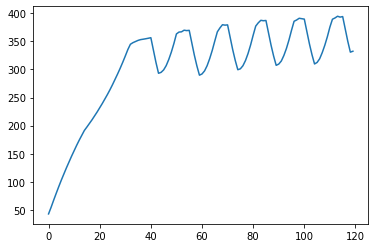

In [8]:
df['Cow_body_weight'].plot()

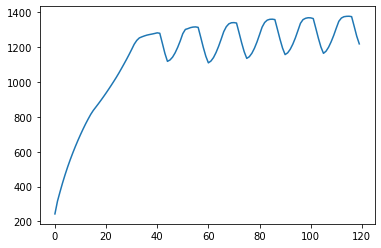

In [9]:
df['ReqAFRC_requirement_ME_maintenance'].plot()

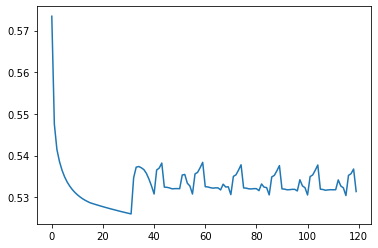

In [10]:
df['ReqAFRC_Q_m'].plot()

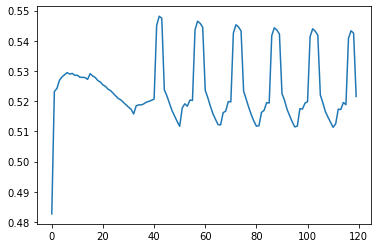

In [11]:
df['ReqAFRC_requirement_ME_maintenance'].divide(30).divide(df['Cow_body_weight'].pow(0.75)).plot()

In [12]:
bw = df['Cow_body_weight']
maint_ME = df['ReqAFRC_requirement_ME_maintenance'].divide(30)

bla = [maint_ME[i] / bw[i]**0.75 for i in range(len(bw))]

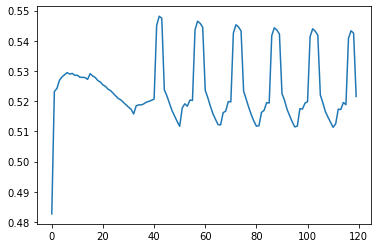

In [13]:
plt.plot(bla)

(MJ NE / month) / x = MJ ME / month

(MJ NE / month) / (MJ NE / MJ ME) = MJ ME / month

(MJ NE / month) * (MJ ME / MJ NE) = MJ ME / month


(MJ NE * MJ ME) / (month * MJ NE)

k_m is in MJ NE / MJ ME


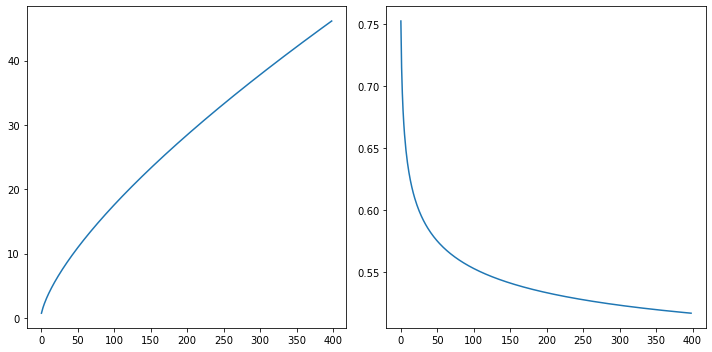

In [14]:
bw = np.arange(1, 400, 1)

# Maintenance requirements according to AFRC (1993)
qm = 0.612  # see Jenet et al. 2004 p. 334
f = 0.53 * bw**0.67
a = 0.0095 * bw
km = 0.35 * qm + 0.503
requirement_AFRC = (f + a) / km
per_metabolic_weight = requirement_AFRC / bw**0.75

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(requirement_AFRC)
axes[1].plot(per_metabolic_weight)

plt.tight_layout()

In [15]:
bw = 306.896076041955

qm = 0.484  # see Jenet et al. 2004 p. 334
f = 0.53 * bw**0.67
a = 0.0095 * bw
km = 0.35 * qm + 0.503
requirement_AFRC = (f + a) / km
f, a, km, requirement_AFRC

(24.578765406691055, 2.915512722398572, 0.6724, 40.88976521280432)

In [16]:
qm = df['ReqAFRC_Q_m']
f = df['ReqAFRC_requirement_NE_fasting']
a = df['ReqAFRC_requirement_NE_activity']
km = df['ReqAFRC_efficiency_ME_maintenance']

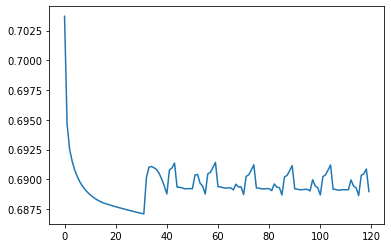

In [17]:
plt.plot(df['ReqAFRC_efficiency_ME_maintenance'])


(0.0, 50.0)

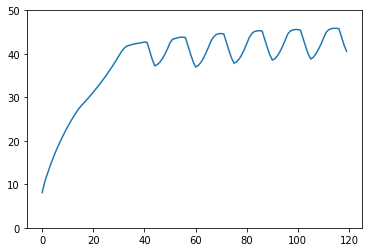

In [18]:
df['ReqAFRC_requirement_ME_maintenance'].divide(30).plot()
plt.ylim(0, 50)

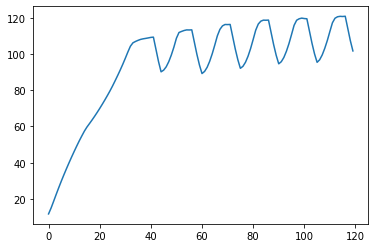

In [19]:
df['ReqAFRC_requirement_NE_activity'].plot()

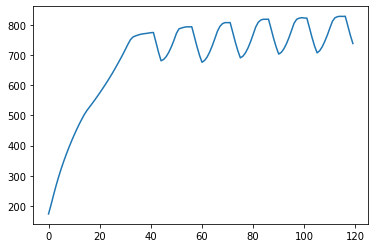

In [20]:
df['ReqAFRC_requirement_NE_fasting'].plot()

In [21]:
echm = 2.6
distance = 1000*30

echm

2.6

In [22]:
10/0.4184

23.90057361376673